---

## Movie Scripts

----

This is a script to work with the movie scripts. We found 3 of them online, which we will start to do some preprocessing on:

In [1]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [2]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [3]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [4]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [5]:
sum([len(ep) for ep in cleaned_episodes])

2523

We now have the cleaned datasets with the character speaking and the corresponding dialogue. We have 2523 dialogues

---

## Movie Script Analysis

We will now start making graph based on the movie scripts. We will start by defining some helper functions to help us get some information about each episode:
- nodes
- links
- nodes with most links

In [6]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [7]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  206
Number of links for Episode V:  148
Number of links for Episode VI:  146


We then get the information for each episode as seen above.

In [8]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  500


We have decided to work with non-weighted edges for now as we want to find some characters with a growing social structure and connections and not the ones that simply just get better connections to the same people.

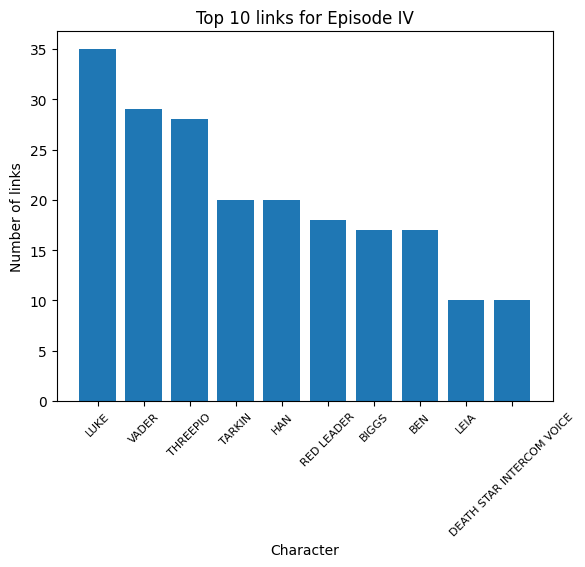

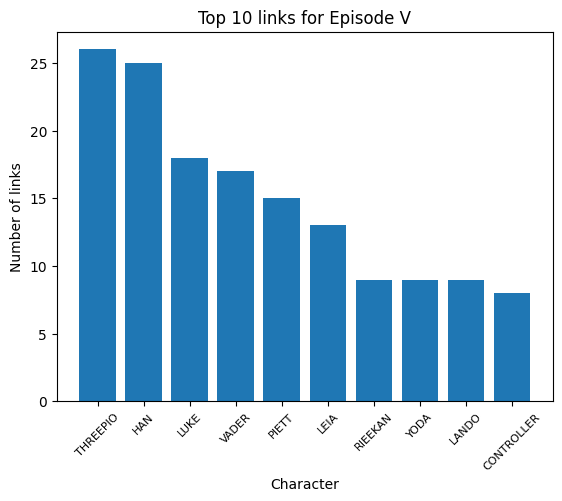

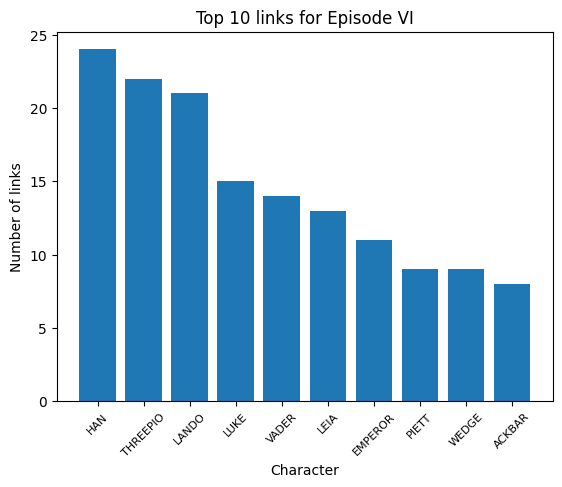

In [9]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time. 

From the diagrams above we have identified the 5 main characters: Luke, C-3PO (Threepio), Han, Leia and Vader. We will do more work on these characters:

In [10]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        all_nodes.append(nodes_for_each_ep[:])
        all_links.append(links_for_each_ep[:])
    print("Nodes: ", [len(node) for node in all_nodes])
    print("Links: ", [len(link) for link in all_links])
    return all_nodes, all_links

def number_of_links_lst(all_nodes, all_links):
    return [len(node) for node in all_nodes], [len(link) for link in all_links]

In [11]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, font_size = 5, ax=axs[i])
        #plt.title(f"Episode {i+4}")
        #plt.show()
        axs[i].set_title(f'Episode {i+1}')

We will start by analyzing Lukes social connections and the development of the social structure around in him first:

In [12]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)

Nodes:  [39, 65, 86]
Links:  [39, 65, 86]


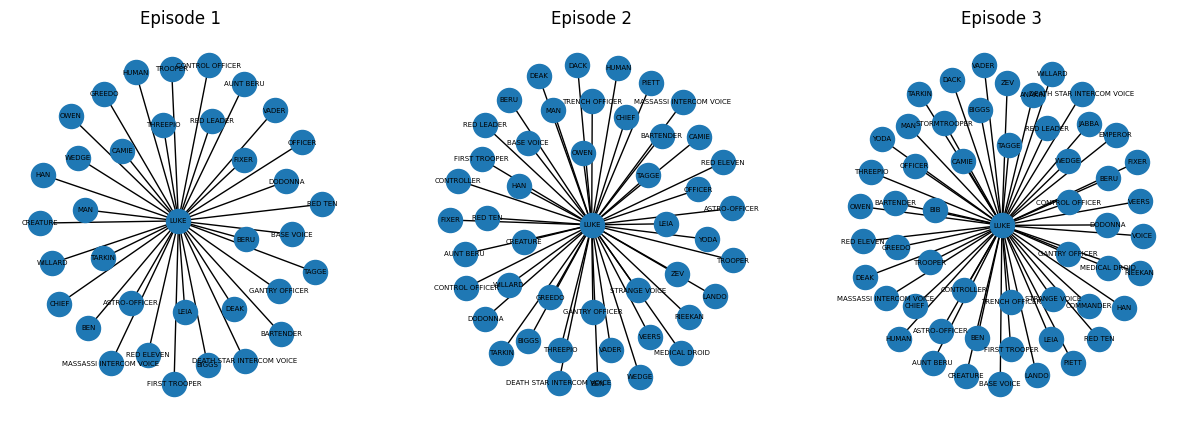

In [13]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
luke_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

----

We will now replicate this for the other main characters:

#### Threepio

Nodes:  [29, 55, 77]
Links:  [29, 55, 77]


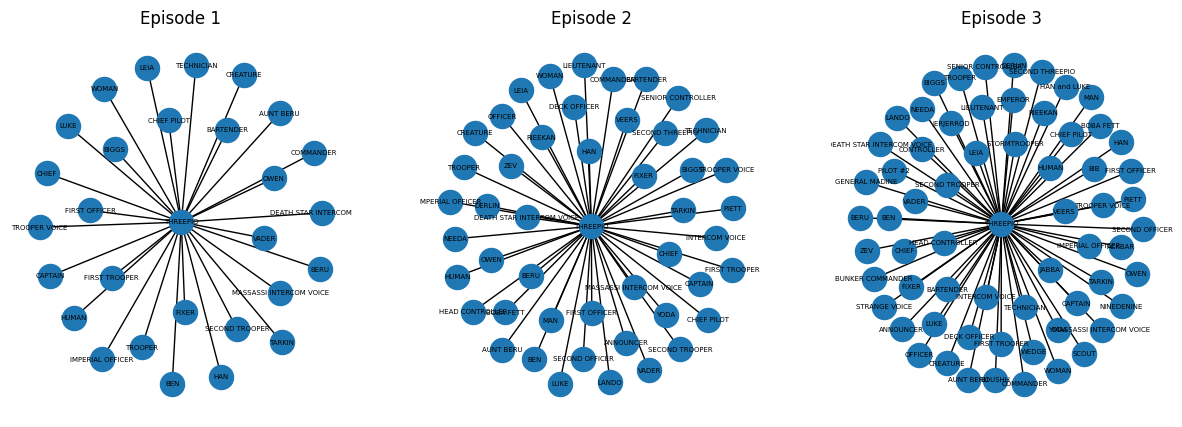

In [14]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("threepio", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
threepio_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### Vader

Nodes:  [29, 46, 61]
Links:  [29, 46, 61]


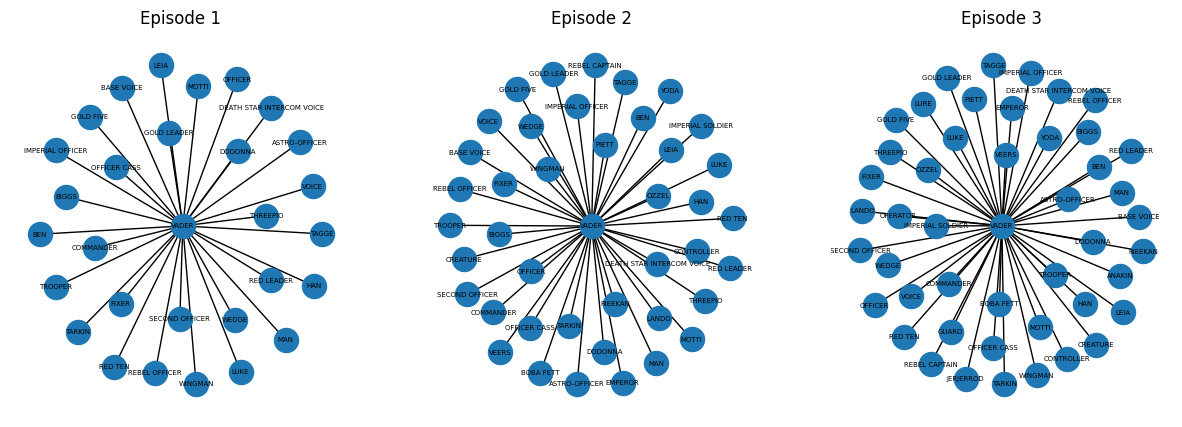

In [15]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("vader", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
vader_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### HAN

Nodes:  [21, 47, 73]
Links:  [21, 47, 73]


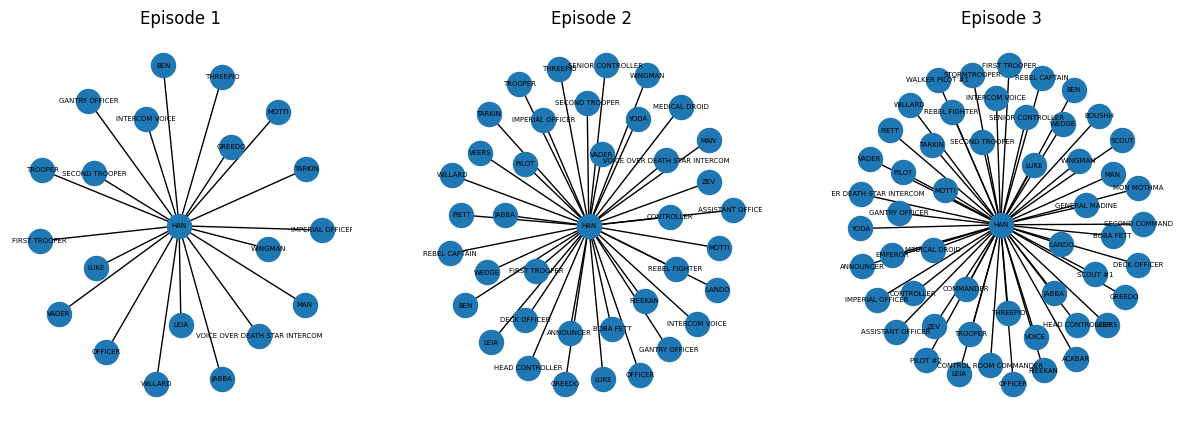

In [16]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("han", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
han_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

### LEIA

Nodes:  [10, 24, 37]
Links:  [10, 24, 37]


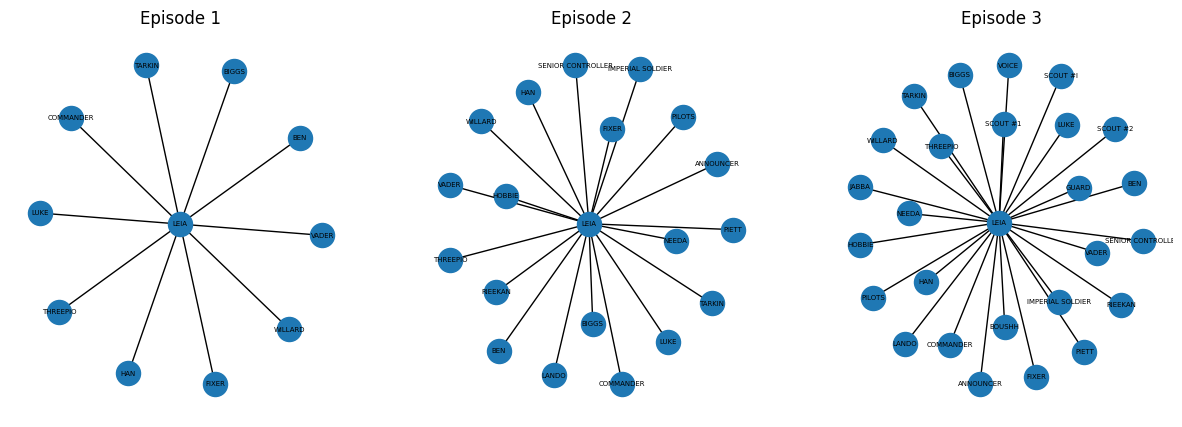

In [17]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("leia", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
leia_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

We can see that all characters develop their relationsships and connections over time.

---

To get a better understanding of how many new connections each character makes, we can determine the procent growth relative to episode 4:

In [18]:
def procent_rise(args):
    nodes, links = args
    nodes_percentage = [round((node - nodes[0])/nodes[0]*100, 2) for node in nodes]
    links_percentage = [round((link - links[0])/links[0]*100, 2) for link in links]
    print("Rise in nodes: ", [str(per) + "%" for per in nodes_percentage])
    print("Rise in links: ", [str(per) + "%" for per in links_percentage], "\n")
    return nodes_percentage, links_percentage

names = ["Luke", "Threepio", "Vader", "Han", "Leia"]
lengths = [luke_len, threepio_len, vader_len, han_len, leia_len]

for name, length in zip(names, lengths):
    print(f"{name}")
    procent_rise(length)

Luke
Rise in nodes:  ['0.0%', '66.67%', '120.51%']
Rise in links:  ['0.0%', '66.67%', '120.51%'] 

Threepio
Rise in nodes:  ['0.0%', '89.66%', '165.52%']
Rise in links:  ['0.0%', '89.66%', '165.52%'] 

Vader
Rise in nodes:  ['0.0%', '58.62%', '110.34%']
Rise in links:  ['0.0%', '58.62%', '110.34%'] 

Han
Rise in nodes:  ['0.0%', '123.81%', '247.62%']
Rise in links:  ['0.0%', '123.81%', '247.62%'] 

Leia
Rise in nodes:  ['0.0%', '140.0%', '270.0%']
Rise in links:  ['0.0%', '140.0%', '270.0%'] 



Han and Leia seems to be the ones with the most growing connections. This could be due to two different theories:
- They are the more important and have more dialogues that the other main characters and thus making more connections
- There were simply just not present in the first movie thus making a extraordinary growth

We can first check the total number of links for all episode for each of the characters:

In [19]:
def character_links_all_episodes(name, nodes, links):
    nodes = [element for lst in nodes for element in lst]
    links = [element for lst in links for element in lst]
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    return number_of_links[name]

def character_dialogues_all_episode(name):
    return sum([len(df[df['character'] == name]) for df in cleaned_episodes])

names = ["Luke", "Threepio", "Vader", "Han", "Leia"]
for name in names:
    print(f"{name}: Total Links: {character_links_all_episodes(name.upper(), nodes, links)}, Total Dialogues: {character_dialogues_all_episode(name.upper())}")

Luke: Total Links: 61, Total Dialogues: 494
Threepio: Total Links: 75, Total Dialogues: 301
Vader: Total Links: 60, Total Dialogues: 140
Han: Total Links: 69, Total Dialogues: 459
Leia: Total Links: 34, Total Dialogues: 227


It seems that all characters end up having the (very close to) same number of connections at the end. 

We can see that they do not have the same amount of dialogues, which means some people interact more with each other than others (we can imagine Luke and Threepio have a pretty strong connection and a lot of dialogues together. 

This proves that the first hypothesis is wrong. Han and Leia does not significantly more dialogues with others that the other main characters have (although Han is at the top for sure!)

By looking and the graphs made before, we can see that both Han and Leia have a small amount of connections in the first movie. Based on the diagrams at the top of this section, we can also see that both Han and Leia have a significantly lower amount of dialogues in the first movie compared to the other characters.

This matches the story line and movie pretty well, as both of them are not as present in the first movie as they later (in movie 5 and 6), where they become much more of a main character.

----

## Word Frequency

We will now work on the word frequency. We will use the completely same TF-IDF algorithm as previously explained, so we will not explain it again.

We did however run into a pretty big problem; we only wanted Star-Wars specific words and no other commen words in our diagrams. As we only had Star Wars texts, our TF-IDF did not work properly. We decided to use NLTK and use their 'brown news', which includes science fiction articles, to get some other texts and then be able to make the proper TF-IDF in comparison to those texts. By doing so, we were able to very Star Wars specific words:

In [20]:
dialogues = [ep["dialogue"].values for ep in cleaned_episodes]
dialogues[0]

array(["Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!",
       "We're doomed!",
       "There'll be no escape for the Princess this time.", ...,
       "We'll get to work on him right away.",
       "You must repair him!  Sir, if any of my circuits or gears will help, I'll gladly donate them.",
       "He'll be all right."], dtype=object)

In [21]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation
from collections import Counter, defaultdict
from statistics import mode
import numpy as np

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()

# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit(): # Remove digits
                continue
            elif token in punctuation or token in ["'s","'re","'ve","'ll",] or token in stopwords: # Remove punctuation and stopwords
                continue
            elif any(symbol in token for symbol in ["`","’",".","--"]):
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

Here we include the nltk browns news corpus to have something to compare the words from the movie dataset to. This did significantly improve the results, especially when we don't include the brown corpus in the final TF-IDF graphs.

In [22]:
from nltk.corpus import brown
text_brown = " ".join(brown.words(categories="news"))
text_brown_tokens = get_tokens(text_brown)
def func():
    for i in range(0, len(text_brown_tokens), 10_500):
        yield text_brown_tokens[i:i + 10_500]

texts = [(" ".join(dialogue)).lower() for dialogue in dialogues]
documents = list(map(get_tokens, texts)) + list(func())
number_of_documents = len(documents)

# Tokenizing the entire corpus:
star_wars_vocab = word_tokenize(" ".join(texts).lower())
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# TF and IDF formulas:
IDF = lambda term_count: np.log10(number_of_documents / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum([list(set(tokens)) for tokens in documents], [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

# Function to calculate the word-frequency-dictionaries for each group in a list of communities:
def get_TF_IDF(communities, single=False):
    if single: communities = [communities]
    
    community_TF_IDF = []
    for group in communities:
        group_total_tokens = sum(group["tokens"], []) # Adding all tokens of the group together.
        group_total_tokens_count = Counter(group_total_tokens)
        
        # Calculating the TF-IDF and making it into a dictionary:
        tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
        community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
    if single: return community_TF_IDF[0]
    return community_TF_IDF

In [23]:
sum(documents, [])
tokens_sw2 = list(map(get_tokens, texts))

dict1 = []
for i in tokens_sw2:
    docs_counter = Counter(i)
    tf_idf = {token_beautifier(word): TF(count, len(i)) * IDF_dict[word] for word, count in docs_counter.items()}
    dict1.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))

For the first movie we then get these words, which are the 'Star wars specific' words that is the most present for this movie

In [24]:
first_n_dict = lambda dicter, n: {k: dicter[k] for k in list(dicter)[:n]}
first_n_dict(dict1[0], 10)

{'luke': 0.34682123712861923,
 'kenobi': 0.30888766431767645,
 'sir': 0.24927776418619507,
 'alderaan': 0.216763273205387,
 'droid': 0.2147097120364333,
 'oh': 0.1763686920299274,
 'biggs': 0.16257245490404024,
 'planet': 0.16257245490404024,
 'artoo': 0.14569587602472261,
 'obi-wan': 0.14569587602472261}

We can then make plots to view for all 3 movies:

C:\Users\alexa\AppData\Local\Temp\ipykernel_2740\1344172804.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)


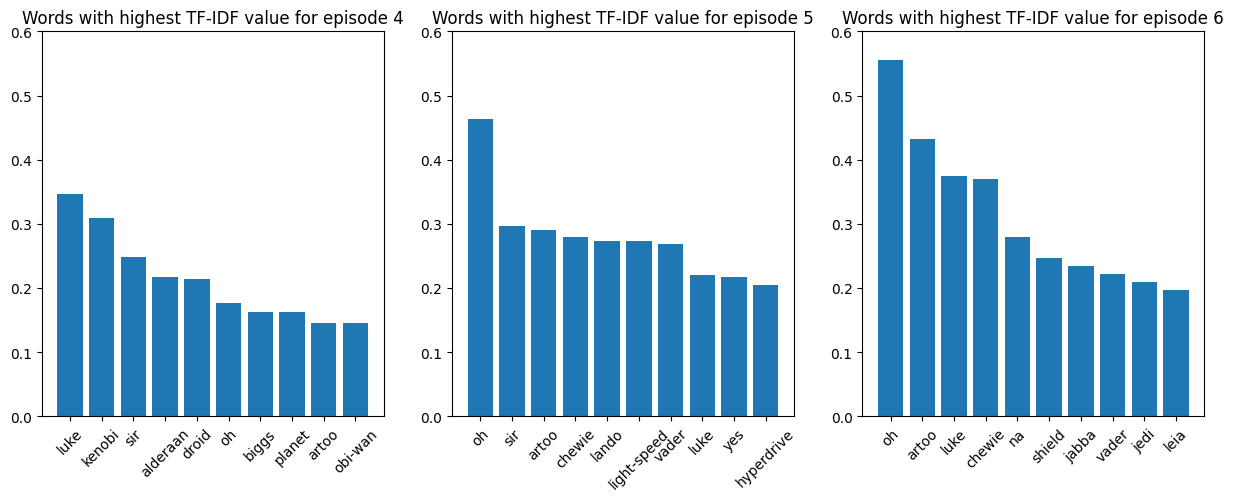

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    common_words = list(dict1[i].keys())[:10]
    word_freq = list(dict1[i].values())[:10]

    axs[i].bar(common_words, word_freq)
    axs[i].set_title(f"Words with highest TF-IDF value for episode {i+4}")
    axs[i].set_xticklabels(common_words, rotation=45)
    axs[i].set_ylim(0, 0.6)
    # axs[i].set_ylabel("Frequency")
    # axs[i].get_yaxis().set_visible(False)

In [65]:
clean_ep4 = cleaned_episodes[0].set_index("character")
clean_ep5 = cleaned_episodes[1].set_index("character")
clean_ep6 = cleaned_episodes[2].set_index("character")

cleaned_episodes[1].groupby('character')["dialogue"].apply(lambda x: " ".join(x))

character
ANNOUNCER                 Headquarters personnel, report to command  cen...
ASSISTANT OFFICER         I'll cover sector twelve. Have com-control set...
BEN                       Luke...Luke. You will go to the Dagobah system...
BOBA FETT                 As you wish. He's no good to me dead. What if ...
CAPTAIN                                   Good. Our first catch of the day.
COMMUNICATIONS OFFICER    Captain, Lord Vader demands an update on the  ...
CONTROLLER                General, there's a fleet of Star Destroyers co...
CREATURE                  Away with your weapon! I mean you no harm. I a...
DACK                      Feeling all right, sir? Right now I feel I cou...
DECK OFFICER              Yes, sir? I haven't seen him. It's possible he...
DERLIN                    Your Highness, there's nothing more we can do ...
EMPEROR                   There is a great disturbance in the Force. We ...
FIRST CONTROLLER                                                  Yes, sir.
HA